In [416]:
#importing necessary libraries 
import pandas as pd
import hvplot.pandas
import numpy as np
import json
import csv 
import matplotlib.pyplot as plt
import requests
import scipy.stats as st
from scipy.stats import linregress
import os

from api_key import geoapify_key # importing api key

# importing the csv file
# csvpath = os.path.join("traffic-crashes-1 (2).csv")

# with open(csvpath) as csvfile:
#     csvreader = csv.reader(csvfile, delimiter = ",")
#     csvheader = next(csvreader) 

traffic_data = pd.read_csv("traffic-crashes-1.csv")
traffic_data.columns


Index(['FID_1', 'OBJECTID', 'Crash_Seve', 'County', 'Crash_Date', 'Crash_Year',
       'Crash_Time', 'Primary_St', 'Distance', 'Dir', 'Secondary_', 'Weather',
       'Fatalities', 'Injured', 'Property_D', 'Injury_Typ', 'Crash_Type',
       'Total_Vehi', 'V1_Type', 'V1_Dir', 'V1_Driver_', 'V1_Lane_Nu',
       'V1_Action', 'V1_Driver1', 'V1_Drive_1', 'V1_Vehicle', 'V1_Most_Ha',
       'V1_All_Eve', 'V2_Type', 'V2_Dir', 'V2_Driver_', 'V2_Lane_Nu',
       'V2_Action', 'V2_Driver1', 'V2_Drive_1', 'V2_Vehicle', 'V2_Most_Ha',
       'V2_All_Eve', 'First_Harm', 'Nonmotoris', 'Factors_Ro', 'Lighting',
       'HWY_Factor', 'Agency', 'Accident_R', 'Pedalcycli', 'Pedestrian',
       'Motorcycli', 'AnimalType', 'X', 'Y', 'OBJECTID_1', 'AREA', 'PERIMETER',
       'WARD', 'CNTY_IS', 'SHADE', 'ACRES', 'SQ_MILES', 'AREA_1', 'LEN'],
      dtype='object')

In [276]:
clean_traffic_data = traffic_data[["County",
                                   "Fatalities",
                                   "Injured",
                                   "Primary_St",
                                   "Crash_Seve",
                                   "Crash_Date",
                                   "Weather",
                                   "Crash_Type",
                                   "V1_Type",
                                   "V1_Driver1",
                                   "V1_Driver_",
                                   "Factors_Ro",
                                   "Lighting",
                                   "X",
                                   "Y"]].copy()
clean_traffic_data = pd.DataFrame(clean_traffic_data)
clean_traffic_data.head(5)

,County,Fatalities,Injured,Primary_St,Crash_Seve,Crash_Date,Weather,Crash_Type,V1_Type,V1_Driver1,V1_Driver_,Factors_Ro,Lighting,X,Y
0,CLARK,NaN,0,ECHELON POINT DR,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,REAR-END,"HATCHBACK, 4 DOOR",APPARENTLY NORMAL,49,DRY,DAYLIGHT,-115.296856,36.282588
1,CLARK,NaN,1,GRAND CANYON DR,INJURY CRASH,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 4 DOOR",HAD BEEN DRINKING,22,DRY,DARK - NO LIGHTING,-115.305960,36.313917
2,CLARK,NaN,0,SKY POINTE DR,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 2 DOOR",HAD BEEN DRINKING,22,DRY,DARK - CONTINUOUS LIGHTING,-115.266269,36.279880
3,CLARK,NaN,0,CC215S,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,NON-COLLISION,SEDAN,NaN,0,WET,DARK - SPOT LIGHTING,-115.283121,36.278732
4,CLARK,NaN,0,US95N,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 4 DOOR",APPARENTLY NORMAL,27,DRY,DARK - NO LIGHTING,-115.312353,36.327534


In [277]:
clean_traffic_data[["County","Crash_Seve"]]

,County,Crash_Seve
0,CLARK,PROPERTY DAMAGE ONLY
1,CLARK,INJURY CRASH
2,CLARK,PROPERTY DAMAGE ONLY
3,CLARK,PROPERTY DAMAGE ONLY
4,CLARK,PROPERTY DAMAGE ONLY
...,...,...
12715,CLARK,PROPERTY DAMAGE ONLY
12716,CLARK,INJURY CRASH
12717,CLARK,INJURY CRASH
12718,CLARK,INJURY CRASH


In [278]:
clean_traffic_data["Fatalities"] = clean_traffic_data["Fatalities"].fillna(0)
len(clean_traffic_data)

12720

In [279]:
clean_traffic_data = clean_traffic_data.rename(columns={"Crash_Seve": "Crash Severity",
                                                        "Crash_Date": "Crash Date",
                                                        "Crash_Type": "Crash Type",
                                                        "V1_Type":"Vehicle_Type",
                                                        "V1_Driver1":"Impairment Level",
                                                        "V1_Driver_": "Age",
                                                        "Factors_Ro": "Road Conditions",
                                                        "X": "Latitude",
                                                        "Y": "Longitude"})
clean_traffic_data.head(3)


,County,Fatalities,Injured,Primary_St,Crash Severity,Crash Date,Weather,Crash Type,Vehicle_Type,Impairment Level,Age,Road Conditions,Lighting,Latitude,Longitude
0,CLARK,0.0,0,ECHELON POINT DR,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,REAR-END,"HATCHBACK, 4 DOOR",APPARENTLY NORMAL,49,DRY,DAYLIGHT,-115.296856,36.282588
1,CLARK,0.0,1,GRAND CANYON DR,INJURY CRASH,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 4 DOOR",HAD BEEN DRINKING,22,DRY,DARK - NO LIGHTING,-115.305960,36.313917
2,CLARK,0.0,0,SKY POINTE DR,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 2 DOOR",HAD BEEN DRINKING,22,DRY,DARK - CONTINUOUS LIGHTING,-115.266269,36.279880


In [280]:
clean_traffic_data = clean_traffic_data.dropna()
clean_traffic_data.head(5)

,County,Fatalities,Injured,Primary_St,Crash Severity,Crash Date,Weather,Crash Type,Vehicle_Type,Impairment Level,Age,Road Conditions,Lighting,Latitude,Longitude
0,CLARK,0.0,0,ECHELON POINT DR,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,REAR-END,"HATCHBACK, 4 DOOR",APPARENTLY NORMAL,49,DRY,DAYLIGHT,-115.296856,36.282588
1,CLARK,0.0,1,GRAND CANYON DR,INJURY CRASH,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 4 DOOR",HAD BEEN DRINKING,22,DRY,DARK - NO LIGHTING,-115.305960,36.313917
2,CLARK,0.0,0,SKY POINTE DR,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 2 DOOR",HAD BEEN DRINKING,22,DRY,DARK - CONTINUOUS LIGHTING,-115.266269,36.279880
4,CLARK,0.0,0,US95N,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 4 DOOR",APPARENTLY NORMAL,27,DRY,DARK - NO LIGHTING,-115.312353,36.327534
6,CLARK,0.0,0,GASS AVE,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,ANGLE,"SEDAN, 2 DOOR",HAD BEEN DRINKING: OTHER IMPROPER DRIVING,26,DRY,DARK - CONTINUOUS LIGHTING,-115.146042,36.160959


In [281]:
#Day or evening occurance
crash_stats_mean = clean_traffic_data.groupby("Crash Type")["Age"].mean()
crash_stats_med = clean_traffic_data.groupby("Crash Type")["Age"].median()
crash_stats_var = clean_traffic_data.groupby("Crash Type")["Age"].var()
crash_stats_std = clean_traffic_data.groupby("Crash Type")["Age"].std()
crash_stats_sem = clean_traffic_data.groupby("Crash Type")["Age"].sem()

age_stats = pd.DataFrame({"Mean age":crash_stats_mean,"Med age":crash_stats_med,"Var age":crash_stats_var,"Std age":crash_stats_std,"Sem age":crash_stats_sem})
age_stats


,Mean age,Med age,Var age,Std age,Sem age
Crash Type,,,,,
ANGLE,39.127315,35.0,339.122315,18.415274,0.315773
BACKING,42.213115,42.0,378.970492,19.467164,2.492515
HEAD-ON,35.146341,29.0,357.478049,18.907090,2.952791
NON-COLLISION,34.872903,30.0,245.258852,15.660742,0.397783
REAR-END,35.080683,31.0,235.754999,15.354315,0.246913
REAR-TO-REAR,34.695652,34.0,161.675889,12.715183,2.651299
"SIDESWIPE, MEETING",41.258929,40.0,324.878298,18.024381,1.703144
"SIDESWIPE, OVERTAKING",38.782958,37.0,255.001126,15.968755,0.640289
UNKNOWN,36.352941,37.0,333.617647,18.265203,4.429962


In [282]:
age_stats_agg = clean_traffic_data.groupby("Crash Type")[["Age"]].agg(["mean","median","var","std","sem"])
round(age_stats_agg,2)

Age                            
                        mean median     var    std   sem
Crash Type                                              
ANGLE                  39.13   35.0  339.12  18.42  0.32
BACKING                42.21   42.0  378.97  19.47  2.49
HEAD-ON                35.15   29.0  357.48  18.91  2.95
NON-COLLISION          34.87   30.0  245.26  15.66  0.40
REAR-END               35.08   31.0  235.75  15.35  0.25
REAR-TO-REAR           34.70   34.0  161.68  12.72  2.65
SIDESWIPE, MEETING     41.26   40.0  324.88  18.02  1.70
SIDESWIPE, OVERTAKING  38.78   37.0  255.00  15.97  0.64
UNKNOWN                36.35   37.0  333.62  18.27  4.43

In [283]:
Weather_by_age = clean_traffic_data.groupby("Weather")["Age"].agg(["mean","median","var","std","sem"])
round(Weather_by_age,2)

,mean,median,var,std,sem
Weather,,,,,
"BLOWING SAND, SOIL, DIRT, SNOW",38.56,35.0,184.53,13.58,4.53
CLEAR,36.82,33.0,281.73,16.78,0.19
CLOUDY,37.43,34.0,298.94,17.29,0.47
"CLOUDY: BLOWING SAND, SOIL, DIRT, SNOW",35.00,35.0,162.00,12.73,9.00
"CLOUDY: FOG, SMOG, SMOKE",20.00,20.0,NaN,NaN,NaN
CLOUDY: RAIN,34.91,31.0,249.27,15.79,1.32
CLOUDY: SEVERE CROSSWINDS,33.67,32.0,184.33,13.58,7.84
"FOG, SMOG, SMOKE",42.25,44.5,377.58,19.43,9.72
OTHER,26.33,22.0,124.33,11.15,6.44


In [284]:
Impairment_by_age = clean_traffic_data.groupby("Impairment Level")["Age"].agg(["mean","median","var","std","sem"])
Impairment_by_age = pd.DataFrame(Impairment_by_age)
Impairment_by_age = round(Impairment_by_age,2)
Impairment_by_age = Impairment_by_age.dropna()
Impairment_by_age

,mean,median,var,std,sem
Impairment Level,,,,,
APPARENTLY NORMAL,37.29,33.0,286.19,16.92,0.19
DRUG INVOLVEMENT,34.37,31.0,190.75,13.81,1.16
DRUG INVOLVEMENT: OTHER IMPROPER DRIVING,53.50,53.5,312.50,17.68,12.50
"FELL ASLEEP, FAINTED, FATIGUED, ETC.",33.86,27.5,269.25,16.41,1.50
"FELL ASLEEP, FAINTED, FATIGUED, ETC.: DRUG INVOLVEMENT",29.83,25.0,161.37,12.70,5.19
"FELL ASLEEP, FAINTED, FATIGUED, ETC.: HAD BEEN DRINKING",31.46,24.0,131.10,11.45,3.18
"FELL ASLEEP, FAINTED, FATIGUED, ETC.: OTHER IMPROPER DRIVING",51.00,51.0,578.00,24.04,17.00
HAD BEEN DRINKING,33.21,30.0,156.91,12.53,0.49
HAD BEEN DRINKING: DRUG INVOLVEMENT,31.80,30.0,157.76,12.56,1.76


In [285]:
Road_by_age = clean_traffic_data.groupby("Road Conditions")["Age"].agg(["mean","median","var","std","sem"])
Road_by_age = round(Road_by_age,2)
Road_by_age = Road_by_age.drop(labels=["ICE","OTHER"],axis=0,inplace=False)
Road_by_age


,mean,median,var,std,sem
Road Conditions,,,,,
DRY,37.0,33.0,286.11,16.91,0.18
WET,35.1,31.0,231.83,15.23,0.51


In [286]:
accident_lighting = clean_traffic_data.groupby(["Lighting", "Weather"])["Lighting"].count()
accident_lighting = pd.DataFrame(accident_lighting)
accident_lighting


Lighting
Lighting                   Weather                                         
DARK - CONTINUOUS LIGHTING CLEAR                                        992
                           CLOUDY                                       117
                           CLOUDY: RAIN                                  18
                           OTHER                                          1
                           RAIN                                          28
                           SEVERE CROSSWINDS                              1
DARK - NO LIGHTING         BLOWING SAND, SOIL, DIRT, SNOW                 1
                           CLEAR                                         76
                           CLOUDY                                        10
                           RAIN                                           9
DARK - SPOT LIGHTING       BLOWING SAND, SOIL, DIRT, SNOW                 1
                           CLEAR                                       1284
                           CLOUDY                                       187
                           CLOUDY: RAIN                                  25
                           CLOUDY: SEVERE CROSSWINDS                      1
                           FOG, SMOG, SMOKE                               2
                           OTHER                                          1
                           RAIN                                         126
                           SEVERE CROSSWINDS                              2
                           UNKNOWN                                        5
DARK - UNKNOWN LIGHTING    CLEAR                                          5
                           RAIN                                           1
                           UNKNOWN                                        1
DAWN                       CLEAR                                        124
                           CLOUDY                                        11
                           CLOUDY: RAIN                                   3
                           RAIN                                           8
DAYLIGHT                   BLOWING SAND, SOIL, DIRT, SNOW                 7
                           CLEAR                                       5241
                           CLOUDY                                       977
                           CLOUDY: BLOWING SAND, SOIL, DIRT, SNOW         2
                           CLOUDY: FOG, SMOG, SMOKE                       1
                           CLOUDY: RAIN                                  95
                           CLOUDY: SEVERE CROSSWINDS                      1
                           FOG, SMOG, SMOKE                               2
                           OTHER                                          1
                           RAIN                                         113
                           RAIN: BLOWING SAND, SOIL, DIRT, SNOW           1
                           SEVERE CROSSWINDS                              2
                           UNKNOWN                                       25
DUSK                       CLEAR                                        143
                           CLOUDY                                        34
                           CLOUDY: RAIN                                   2
                           CLOUDY: SEVERE CROSSWINDS                      1
                           RAIN                                           2
                           UNKNOWN                                        1
OTHER                      CLOUDY: RAIN                                   1
UNKNOWN                    CLEAR                                          2

In [287]:
# accident_lighting = accident_lighting.drop(labels=["OTHER","UNKNOWN"],axis=0,inplace=False)
# accident_lighting
#removed other and unknown

In [365]:
clean_traffic_data["day_night"]= clean_traffic_data["Lighting"].str[: 3]
clean_traffic_data

,County,Fatalities,Injured,Primary_St,Crash Severity,Crash Date,Weather,Crash Type,Vehicle_Type,Impairment Level,Age,Road Conditions,Lighting,Latitude,Longitude,day_night,driver_impaired
0,CLARK,0.0,0,ECHELON POINT DR,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,REAR-END,"HATCHBACK, 4 DOOR",APPARENTLY NORMAL,49,DRY,DAYLIGHT,-115.296856,36.282588,DAY,
1,CLARK,0.0,1,GRAND CANYON DR,INJURY CRASH,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 4 DOOR",HAD BEEN DRINKING,22,DRY,DARK - NO LIGHTING,-115.305960,36.313917,DAR,
2,CLARK,0.0,0,SKY POINTE DR,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 2 DOOR",HAD BEEN DRINKING,22,DRY,DARK - CONTINUOUS LIGHTING,-115.266269,36.279880,DAR,
4,CLARK,0.0,0,US95N,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 4 DOOR",APPARENTLY NORMAL,27,DRY,DARK - NO LIGHTING,-115.312353,36.327534,DAR,
6,CLARK,0.0,0,GASS AVE,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,ANGLE,"SEDAN, 2 DOOR",HAD BEEN DRINKING: OTHER IMPROPER DRIVING,26,DRY,DARK - CONTINUOUS LIGHTING,-115.146042,36.160959,DAR,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12714,CLARK,0.0,0,SR599N TO ANN RD INT90B,PROPERTY DAMAGE ONLY,12/31/2016,CLOUDY,REAR-END,CARRY-ALL,APPARENTLY NORMAL,38,DRY,DAYLIGHT,-115.252436,36.262845,DAY,
12715,CLARK,0.0,0,N BUFFALO DR,PROPERTY DAMAGE ONLY,12/31/2016,CLOUDY,NON-COLLISION,"SEDAN, 4 DOOR",HAD BEEN DRINKING,24,DRY,DARK - CONTINUOUS LIGHTING,-115.260731,36.203052,DAR,
12716,CLARK,0.0,1,CLIFF SHADOWS PKWY,INJURY CRASH,12/31/2016,CLEAR,NON-COLLISION,CONVERTIBLE,"FELL ASLEEP, FAINTED, FATIGUED, ETC.",68,DRY,DAYLIGHT,-115.329666,36.239294,DAY,
12717,CLARK,0.0,3,CHEYENNE AVE,INJURY CRASH,12/31/2016,CLOUDY,REAR-END,"SEDAN, 4 DOOR",APPARENTLY NORMAL,65,DRY,DARK - CONTINUOUS LIGHTING,-115.322318,36.218215,DAR,


In [289]:
accident_lighting = clean_traffic_data.groupby(["day_night"])["day_night"].count()
accident_lighting = pd.DataFrame(accident_lighting)
accident_lighting = accident_lighting.rename(columns={"day_night":"Count"}).reset_index()
accident_lighting

,day_night,Count
0,DAR,2894
1,DAW,146
2,DAY,6468
3,DUS,183
4,OTH,1
5,UNK,2


<function matplotlib.pyplot.show(close=None, block=None)>

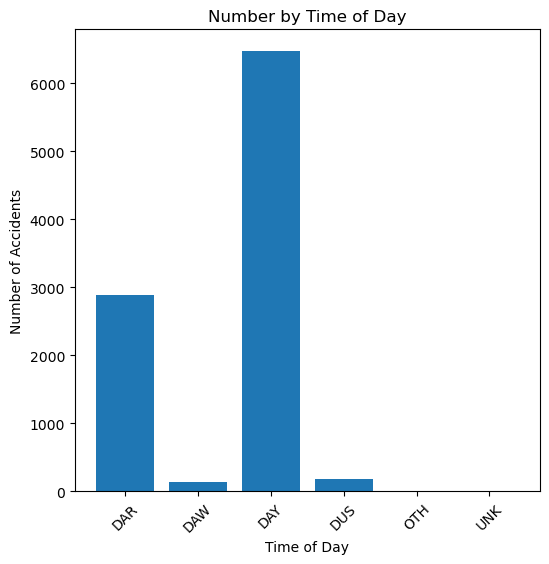

In [290]:
plt.figure(figsize=(6,6))
plt.bar(accident_lighting["day_night"],accident_lighting["Count"],align= "center")
plt.title("Number by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Accidents")
plt.xticks(rotation = 45)

plt.show

In [291]:
accident_int = clean_traffic_data.groupby(["Primary_St"])["Primary_St"].value_counts()
accident_int 

Primary_St
28TH ST                2
30TH ST                1
ALPINE PL              1
ALTA DR               61
AMY OLIVIA AVE         1
                      ..
WINDROSE POINT AVE     1
WING ST                1
WOODBRIDGE DR          1
WOODLAND RIDGE ST      1
WYANDOTTE ST           1
Name: count, Length: 647, dtype: int64

In [292]:
accident_int = pd.DataFrame(accident_int)
accident_int = accident_int.sort_values("count", ascending=False)
accident_int.head(3)


,count
Primary_St,
IR15N,960
US95S,700
US95N,596


In [293]:
accident_street_df = clean_traffic_data[[ "County", "Age", "Latitude","Longitude", "Primary_St"]].copy()
accident_street_df

,County,Age,Latitude,Longitude,Primary_St
0,CLARK,49,-115.296856,36.282588,ECHELON POINT DR
1,CLARK,22,-115.305960,36.313917,GRAND CANYON DR
2,CLARK,22,-115.266269,36.279880,SKY POINTE DR
4,CLARK,27,-115.312353,36.327534,US95N
6,CLARK,26,-115.146042,36.160959,GASS AVE
...,...,...,...,...,...
12714,CLARK,38,-115.252436,36.262845,SR599N TO ANN RD INT90B
12715,CLARK,24,-115.260731,36.203052,N BUFFALO DR
12716,CLARK,68,-115.329666,36.239294,CLIFF SHADOWS PKWY
12717,CLARK,65,-115.322318,36.218215,CHEYENNE AVE


### Narrow down the accident_street_df to show top 10 streets that had accidents

In [306]:
clean_accident_data_merge = pd.merge(accident_street_df, accident_int, how="left", on=["Primary_St", "Primary_St"])
clean_accident_data_merge = pd.DataFrame(clean_accident_data_merge)
clean_accident_data_merge.head(3)

,County,Age,Latitude,Longitude,Primary_St,count
0,CLARK,49,-115.296856,36.282588,ECHELON POINT DR,1
1,CLARK,22,-115.305960,36.313917,GRAND CANYON DR,14
2,CLARK,22,-115.266269,36.279880,SKY POINTE DR,20


In [307]:
age_count = clean_accident_data_merge.groupby("Age")["Age"].count()
age_count = age_count.sort_values(ascending=False)
age_count = age_count.head(10)
age_count = pd.DataFrame(age_count)
age_count = age_count
age_count = age_count.rename(columns={"Age":"Count"})
age_count = age_count.reset_index()
age_count = age_count.sort_values("Age",ascending=True)
age_count

,Age,Count
9,18,281
1,19,367
2,20,359
0,21,386
3,22,349
5,23,324
6,24,317
4,25,335
8,26,284
7,27,289


In [422]:
# Age = age_count["Age"]
# unit_labels = [f"{Age} years old" for age in age_count]
# plt.pie(age_count["Count"], autopct='%1.f%%' ,labels=age_count["Age"])
# plt.title("Top 10 Accident  by Ages ")
# plt.xlabel("Age")


# plt.show()


ValueError: Dimensions of labels and X must be compatible

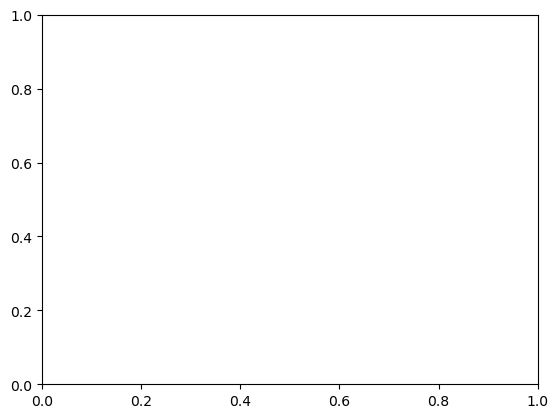

In [462]:
Twenty = clean_traffic_data["Age"][clean_traffic_data["Age"] < 30]
Thirty = clean_traffic_data["Age"][clean_traffic_data["Age"] < 40]

age_group = ["0-20", "21-30", "31-40", "41-50"]

plt.boxplot([Twenty, Thirty], labels=[age_group],
            flierprops={'marker':"o", 'markersize':10, 'markerfacecolor':'red'})
plt.show()


# condition = ["DRY", "ICE", "OTHER","WET"]
# four_road_condtion = clean_traffic_data[clean_traffic_data["Road Conditions"].isin(condition)]

In [308]:
top_street_df = clean_accident_data_merge.loc[(clean_accident_data_merge["count"] >= 149)]
top_street_df = pd.DataFrame(top_street_df)
top_street_df

,County,Age,Latitude,Longitude,Primary_St,count
3,CLARK,27,-115.312353,36.327534,US95N,596
6,CLARK,23,-115.165380,36.150421,IR15N,960
8,CLARK,22,-115.166759,36.148856,IR15N,960
9,CLARK,46,-115.163842,36.152167,IR15N,960
10,CLARK,25,-115.165478,36.150309,IR15N,960
...,...,...,...,...,...,...
9676,CLARK,35,-115.115841,36.167172,EASTERN AVE,153
9680,CLARK,36,-115.173848,36.140799,IR15N,960
9682,CLARK,28,-115.175425,36.139011,IR15N,960
9683,CLARK,39,-115.174834,36.139682,IR15N,960


In [417]:
#Set parameters to search for a street

params = {
    "apiKey": geoapify_key,
    "mode": "drive"
    }

for index, row in top_street_df.iterrows():
    #get latidude and longitude from DataRFrame
    lat = row["Latitude"]
    lng = row ["Longitude"]

    # Add waypoints current street's latitude and longitude to the params dictionary
    params["waypoints"] = f"circle:{lng},{lat}"

base_url = " https://api.geoapify.com/v1/mapmatching"

# Make and API request using the params dictionaty
street_address = requests.get(base_url, params=params)
    
# Convert the API response to JSON format
street_address = street_address.json()
    
# Display sample data
top_street_df

,County,Age,Latitude,Longitude,Primary_St,count
3,CLARK,27,-115.312353,36.327534,US95N,596
6,CLARK,23,-115.165380,36.150421,IR15N,960
8,CLARK,22,-115.166759,36.148856,IR15N,960
9,CLARK,46,-115.163842,36.152167,IR15N,960
10,CLARK,25,-115.165478,36.150309,IR15N,960
...,...,...,...,...,...,...
9676,CLARK,35,-115.115841,36.167172,EASTERN AVE,153
9680,CLARK,36,-115.173848,36.140799,IR15N,960
9682,CLARK,28,-115.175425,36.139011,IR15N,960
9683,CLARK,39,-115.174834,36.139682,IR15N,960


In [419]:
accidents = top_street_df.hvplot.points(
    y="Longitude",
    x="Latitude",
    geo = True,
    width=800,
    height=400,
    color="Primary_St",
    size="Age",
    tiles="OSM",
    hover_cols = ["Primary_St", "County", "Age"])

accidents

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Latitude,Longitude]   (Primary_St,Age,County)

In [309]:
# define function to create linear regression plot
def linear_regression_plot(df, x_col, y_col, title, ylabel, xlabel, color="green"):
    x_data = df[x_col]
    y_data = df[y_col]

    linear_regression = linregress(x_data, y_data)
    plt.scatter(x_data, y_data, facecolors=color, edgecolors="black")

    linear_equation = linear_regression.slope * x_data + linear_regression.intercept

    plt.plot(x_data, linear_equation, "-", color="black")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    print(f"The r value is: {round(r,4)}")
    plt.show()
    

The r value is: -0.0711


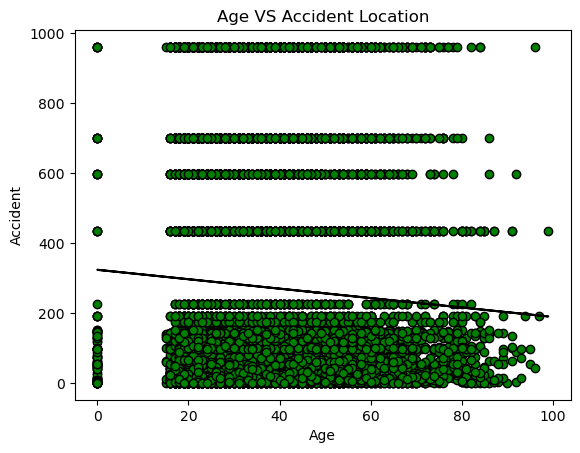

In [310]:
linear_regression_plot(clean_accident_data_merge,"Age","count","Age VS Accident Location","Accident", "Age",color="green")

In [321]:
vehicle_type = clean_traffic_data.groupby("Vehicle_Type")["Age"].count().reset_index()
vehicle_type = vehicle_type.sort_values("Age",ascending=False)
vehicle_type = vehicle_type.head(15)
vehicle_type


,Vehicle_Type,Age
36,"SEDAN, 4 DOOR",3992
6,CARRY-ALL,1584
31,PICKUP,1230
44,VAN,395
20,"HATCHBACK, 4 DOOR",385
35,"SEDAN, 2 DOOR",381
18,"HARDTOP, 4 DOOR",348
43,UTILITY,232
34,SEDAN,170
19,"HATCHBACK, 2 DOOR",141


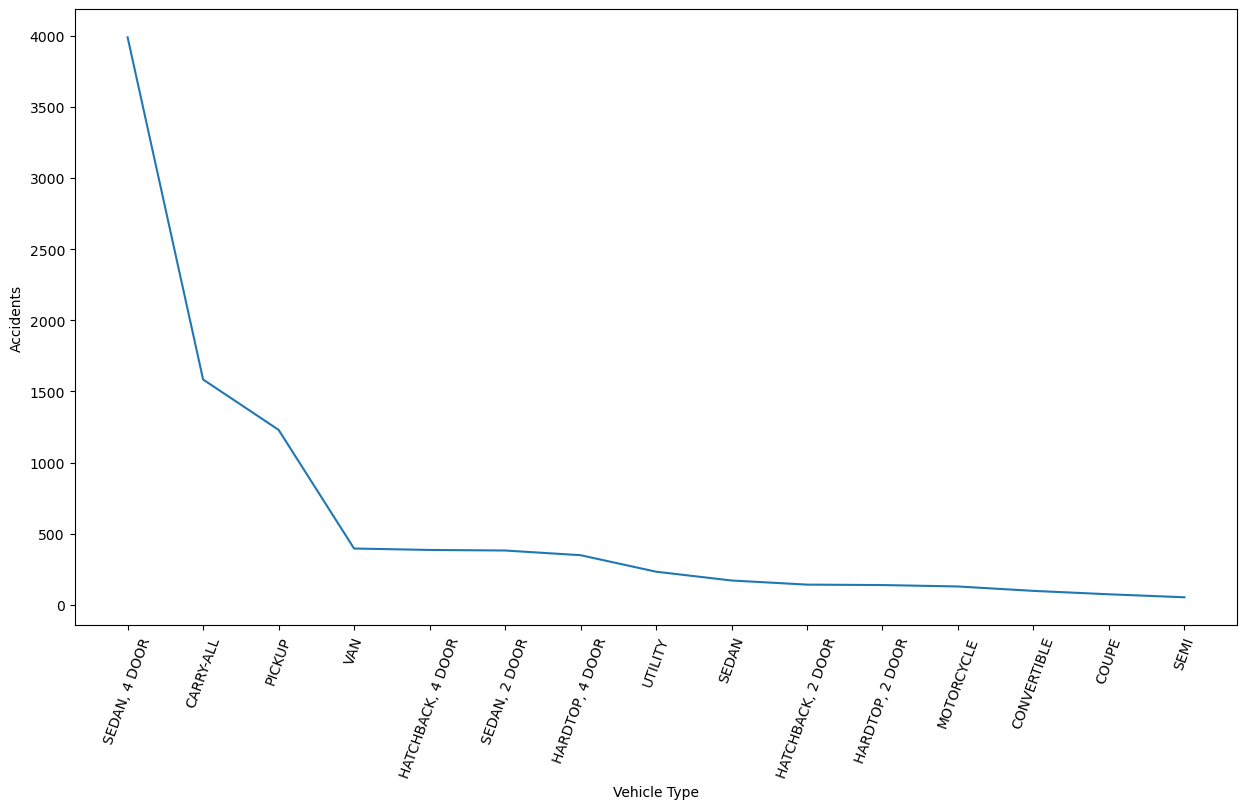

In [345]:
vehicle = vehicle_type['Vehicle_Type']
Total_accidents = vehicle_type['Age']

plt. figure(figsize=(15, 8))
plt.plot(vehicle,Total_accidents)
plt.xticks(rotation = 70)
plt.xlabel("Vehicle Type")
plt.ylabel("Accidents")
plt.show()

In [363]:
clean_traffic_data["driver_impaired"] = ""       

In [373]:
for index, x in clean_traffic_data.iterrows():
    if clean_traffic_data.loc[index,"Impairment Level"] == "APPARENTLY NORMAL":
        clean_traffic_data.loc[index,"driver_impaired"] = "Normal"
    else:
        clean_traffic_data.loc[index,"driver_impaired"] = "Impaired"

In [376]:
clean_accident_data.head(5)

,County,Age,Latitude,Longitude,Primary_St,count
0,CLARK,49,-115.296856,36.282588,ECHELON POINT DR,1
1,CLARK,22,-115.305960,36.313917,GRAND CANYON DR,14
2,CLARK,22,-115.266269,36.279880,SKY POINTE DR,20
3,CLARK,27,-115.312353,36.327534,US95N,596
4,CLARK,26,-115.146042,36.160959,GASS AVE,9


In [378]:
accident_impaired = clean_traffic_data.groupby("driver_impaired")["driver_impaired"].count()
accident_impaired

driver_impaired
Impaired    1747
Normal      7947
Name: driver_impaired, dtype: int64

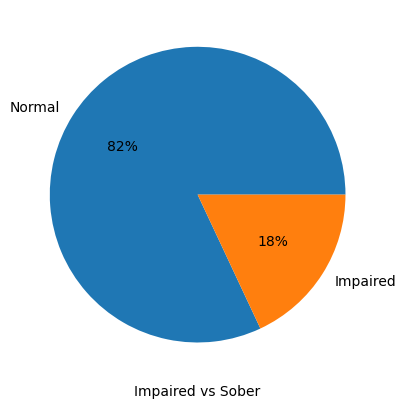

In [405]:
impaired = clean_traffic_data["driver_impaired"].unique()
impaired_count = clean_traffic_data["driver_impaired"].value_counts()

dict1 = {"Impaired":impaired,
         "Impaired_cnt":impaired_count}

df1 = pd.DataFrame(dict1)

plt.pie(df1['Impaired_cnt'],autopct='%1.f%%',labels= df1['Impaired'])
plt.xlabel("Impaired vs Sober")
plt.show()


In [393]:
crash_type = clean_traffic_data.groupby("Crash Type")["Crash Type"].count()
crash_type = pd.DataFrame(crash_type)
crash_type = crash_type.rename(columns={"Crash Type":"Count"})
crash_type = crash_type.reset_index()
crash_type

,Crash Type,Count
0,ANGLE,3401
1,BACKING,61
2,HEAD-ON,41
3,NON-COLLISION,1550
4,REAR-END,3867
5,REAR-TO-REAR,23
6,"SIDESWIPE, MEETING",112
7,"SIDESWIPE, OVERTAKING",622
8,UNKNOWN,17


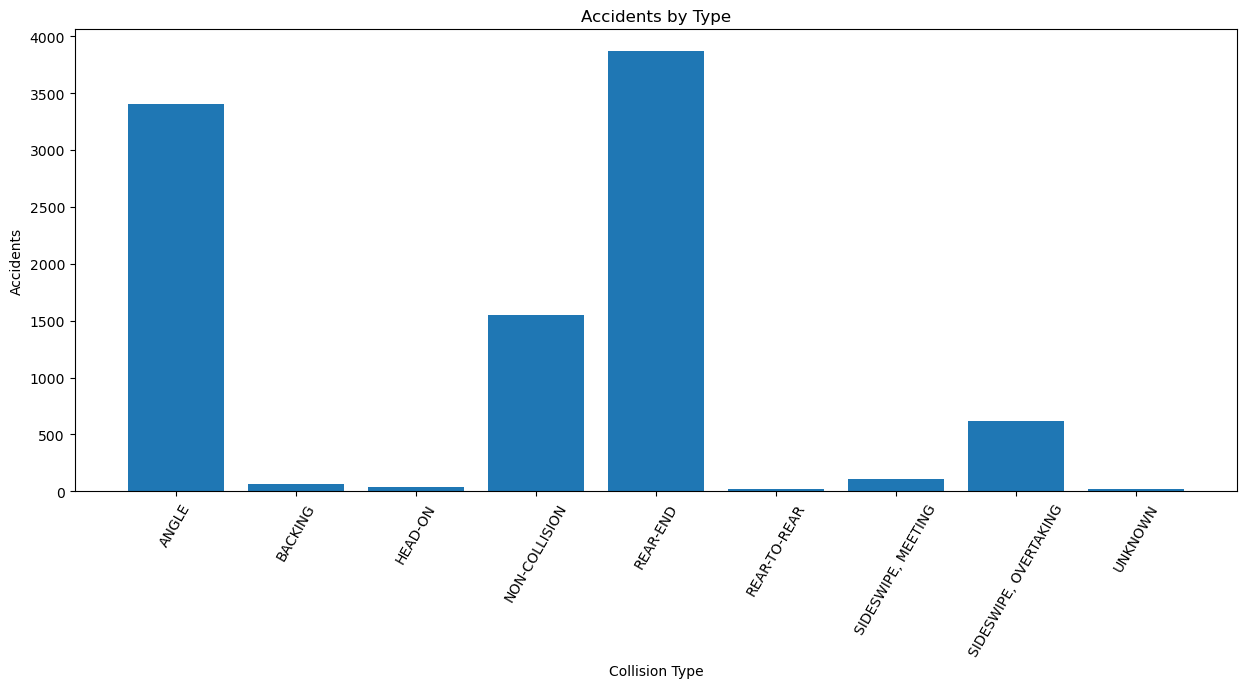

In [403]:
plt.figure(figsize=(15,6))
plt.bar(crash_type["Crash Type"],crash_type["Count"],align= "center")
plt.title("Accidents by Type")
plt.xlabel("Collision Type")
plt.ylabel("Accidents")
plt.xticks(rotation = 60)
plt.show()

In [432]:
#What crash was most severe?
Crash_severity = clean_traffic_data.groupby("Crash Severity").count()
Crash_severity = Crash_severity["County"]
Crash_severity = pd.DataFrame(Crash_severity).reset_index()
Crash_severity = Crash_severity.rename(columns={"County":"Count"})
Crash_severity

,Crash Severity,Count
0,FATAL CRASH,44
1,INJURY CRASH,5399
2,PROPERTY DAMAGE ONLY,4251


In [ ]:

Is there a correlation between vehicle type and road condition?
Is there a correlation between the time of day and the accidents causation?

In [446]:
# Under what road conditions do the most accidents occur?

weather_conditions = clean_traffic_data.groupby("Road Conditions")["Road Conditions"].count()
weather_conditions

Road Conditions
DRY      8790
ICE         1
OTHER       1
WET       902
Name: Road Conditions, dtype: int64

In [442]:
condition = ["DRY", "ICE", "OTHER","WET"]
four_road_condtion = clean_traffic_data[clean_traffic_data["Road Conditions"].isin(condition)]
len(four_road_condtion)

9694

In [433]:
clean_traffic_data

,County,Fatalities,Injured,Primary_St,Crash Severity,Crash Date,Weather,Crash Type,Vehicle_Type,Impairment Level,Age,Road Conditions,Lighting,Latitude,Longitude,day_night,driver_impaired
0,CLARK,0.0,0,ECHELON POINT DR,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,REAR-END,"HATCHBACK, 4 DOOR",APPARENTLY NORMAL,49,DRY,DAYLIGHT,-115.296856,36.282588,DAY,Normal
1,CLARK,0.0,1,GRAND CANYON DR,INJURY CRASH,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 4 DOOR",HAD BEEN DRINKING,22,DRY,DARK - NO LIGHTING,-115.305960,36.313917,DAR,Impaired
2,CLARK,0.0,0,SKY POINTE DR,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 2 DOOR",HAD BEEN DRINKING,22,DRY,DARK - CONTINUOUS LIGHTING,-115.266269,36.279880,DAR,Impaired
4,CLARK,0.0,0,US95N,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,NON-COLLISION,"SEDAN, 4 DOOR",APPARENTLY NORMAL,27,DRY,DARK - NO LIGHTING,-115.312353,36.327534,DAR,Normal
6,CLARK,0.0,0,GASS AVE,PROPERTY DAMAGE ONLY,01/01/2016,CLEAR,ANGLE,"SEDAN, 2 DOOR",HAD BEEN DRINKING: OTHER IMPROPER DRIVING,26,DRY,DARK - CONTINUOUS LIGHTING,-115.146042,36.160959,DAR,Impaired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12714,CLARK,0.0,0,SR599N TO ANN RD INT90B,PROPERTY DAMAGE ONLY,12/31/2016,CLOUDY,REAR-END,CARRY-ALL,APPARENTLY NORMAL,38,DRY,DAYLIGHT,-115.252436,36.262845,DAY,Normal
12715,CLARK,0.0,0,N BUFFALO DR,PROPERTY DAMAGE ONLY,12/31/2016,CLOUDY,NON-COLLISION,"SEDAN, 4 DOOR",HAD BEEN DRINKING,24,DRY,DARK - CONTINUOUS LIGHTING,-115.260731,36.203052,DAR,Impaired
12716,CLARK,0.0,1,CLIFF SHADOWS PKWY,INJURY CRASH,12/31/2016,CLEAR,NON-COLLISION,CONVERTIBLE,"FELL ASLEEP, FAINTED, FATIGUED, ETC.",68,DRY,DAYLIGHT,-115.329666,36.239294,DAY,Impaired
12717,CLARK,0.0,3,CHEYENNE AVE,INJURY CRASH,12/31/2016,CLOUDY,REAR-END,"SEDAN, 4 DOOR",APPARENTLY NORMAL,65,DRY,DARK - CONTINUOUS LIGHTING,-115.322318,36.218215,DAR,Normal
